<a href="https://colab.research.google.com/github/sundarramamurthy/DS/blob/master/Hyper_Parameter_Tuning_with_HyperOpt_Regression_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HyperOpt and HyperOpt-sklearn

HyperOpt is an open-source library for large scale AutoML and HyperOpt-Sklearn is a wrapper for HyperOpt that supports AutoML with HyperOpt for the popular Scikit-Learn machine learning library, including the suite of data preparation transforms and classification and regression algorithms.

# Install HyperOpt Packages

In [1]:
!pip install hyperopt

In [2]:
# !pip install hpsklearn
!pip install git+https://github.com/hyperopt/hyperopt-sklearn.git

  Cloning https://github.com/hyperopt/hyperopt-sklearn.git to /tmp/pip-req-build-h0cu1sx7
  Running command git clone -q https://github.com/hyperopt/hyperopt-sklearn.git /tmp/pip-req-build-h0cu1sx7
     |████████████████████████████████| 154 kB 7.2 MB/s 
  Created wheel for hpsklearn: filename=hpsklearn-0.0.3-py3-none-any.whl size=27011 sha256=569cc97ac56797263a25ef1a9c2cbe19ca5bb83b54120afdfed0ab3424f3d354
  Stored in directory: /tmp/pip-ephem-wheel-cache-33tdj6z_/wheels/47/a5/46/9ca750026db9dfa5de4bf4836194554cb0e2e01a245588ea59
Successfully built hpsklearn


Many different optimization algorithms are available, including:

*  Random Search

* Tree of Parzen Estimators

* Annealing

* Tree

Gaussian Process Tree





The **“Tree of Parzen Estimators” is a good default**, and you can learn more about the types of algorithms in the paper “Algorithms for Hyper-Parameter Optimization.

# Import Packages

In [3]:
import pandas as pd
import datetime
import numpy as np

# Import US Power Consumption Dataset

In [5]:
df = pd.read_csv('/content/power_consumption.csv',parse_dates= ['date'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4427 entries, 0 to 4426
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   code          4427 non-null   object        
 1   area          4427 non-null   object        
 2   date          4427 non-null   datetime64[ns]
 3   municipality  4427 non-null   object        
 4   use           4427 non-null   object        
 5   stratum       4427 non-null   int64         
 6   consumption   4427 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 242.2+ KB


In [7]:
df["date"] = pd.to_datetime(df["date"],errors = 'coerce')

In [8]:
df.head()

,code,area,date,municipality,use,stratum,consumption
0,8UBARI0,U,2010-12-31,BARBACOAS,Industrial,0,953.345
1,8RBARR2,R,2010-12-31,BARBACOAS,Residential,2,1176.137
2,8RBARE0,R,2010-12-31,BARBACOAS,Special,0,1373.956
3,8RBARC0,R,2010-12-31,BARBACOAS,Commercial,0,1684.467
4,8UBARR3,U,2010-12-31,BARBACOAS,Residential,3,4391.084


# Drop the ID columns

In [9]:
df1=df.drop('code',axis=1)

In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4427 entries, 0 to 4426
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   area          4427 non-null   object        
 1   date          4427 non-null   datetime64[ns]
 2   municipality  4427 non-null   object        
 3   use           4427 non-null   object        
 4   stratum       4427 non-null   int64         
 5   consumption   4427 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 207.6+ KB


In [ ]:
# df1['date'] = pd.to_datetime(df1.date, format='%d-%m-%Y',errors = 'coerce',utc=True)

In [ ]:
# df1['date'] = df1['date'].dt.strftime('%Y-%m-%d')

# Create Date Features

In [11]:
df1['year'] = df1.date.dt.year
df1['month'] = df1.date.dt.month
df1['day'] = df1.date.dt.day
df1['day_of_year'] = df1.date.dt.dayofyear
df1['day_of_week'] = df1.date.dt.dayofweek

In [12]:
df1.head()

,area,date,municipality,use,stratum,consumption,year,month,day,day_of_year,day_of_week
0,U,2010-12-31,BARBACOAS,Industrial,0,953.345,2010,12,31,365,4
1,R,2010-12-31,BARBACOAS,Residential,2,1176.137,2010,12,31,365,4
2,R,2010-12-31,BARBACOAS,Special,0,1373.956,2010,12,31,365,4
3,R,2010-12-31,BARBACOAS,Commercial,0,1684.467,2010,12,31,365,4
4,U,2010-12-31,BARBACOAS,Residential,3,4391.084,2010,12,31,365,4


In [13]:
df2 = df1.drop('date',axis=1)

In [14]:
df2.head()

,area,municipality,use,stratum,consumption,year,month,day,day_of_year,day_of_week
0,U,BARBACOAS,Industrial,0,953.345,2010,12,31,365,4
1,R,BARBACOAS,Residential,2,1176.137,2010,12,31,365,4
2,R,BARBACOAS,Special,0,1373.956,2010,12,31,365,4
3,R,BARBACOAS,Commercial,0,1684.467,2010,12,31,365,4
4,U,BARBACOAS,Residential,3,4391.084,2010,12,31,365,4


# Convert Categorical Features to One Hot Encoded Feature

In [15]:
#categorical data
categorical_cols = ['municipality', 'use', 'area'] 

#import pandas as pd
df3 = pd.get_dummies(df2, columns = categorical_cols)

In [16]:
df3.head()

,stratum,consumption,year,month,day,day_of_year,day_of_week,municipality_BARBACOAS,municipality_CUMBITARA,municipality_EL ROSARIO,municipality_LEIVA,municipality_MAGUI,municipality_POLICARPA,municipality_ROBERTO PAYAN,use_Commercial,use_Industrial,use_Official,use_Residential,use_Residential Sub,use_Special,area_R,area_U
0,0,953.345,2010,12,31,365,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,2,1176.137,2010,12,31,365,4,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,0,1373.956,2010,12,31,365,4,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,0,1684.467,2010,12,31,365,4,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,3,4391.084,2010,12,31,365,4,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1


# Rearrange the feature list

In [17]:
df3.columns.tolist()

['stratum',
 'consumption',
 'year',
 'month',
 'day',
 'day_of_year',
 'day_of_week',
 'municipality_BARBACOAS',
 'municipality_CUMBITARA',
 'municipality_EL ROSARIO',
 'municipality_LEIVA',
 'municipality_MAGUI',
 'municipality_POLICARPA',
 'municipality_ROBERTO PAYAN',
 'use_Commercial',
 'use_Industrial',
 'use_Official',
 'use_Residential',
 'use_Residential Sub',
 'use_Special',
 'area_R',
 'area_U']

In [18]:
df3= df3[['stratum',
  'year',
 'month',
 'day',
 'day_of_year',
 'day_of_week',
 'municipality_BARBACOAS',
 'municipality_CUMBITARA',
 'municipality_EL ROSARIO',
 'municipality_LEIVA',
 'municipality_MAGUI',
 'municipality_POLICARPA',
 'municipality_ROBERTO PAYAN',
 'use_Commercial',
 'use_Industrial',
 'use_Official',
 'use_Residential',
 'use_Residential Sub',
 'use_Special',
 'area_R',
 'area_U',
 'consumption']]

In [19]:
df3.head()

,stratum,year,month,day,day_of_year,day_of_week,municipality_BARBACOAS,municipality_CUMBITARA,municipality_EL ROSARIO,municipality_LEIVA,municipality_MAGUI,municipality_POLICARPA,municipality_ROBERTO PAYAN,use_Commercial,use_Industrial,use_Official,use_Residential,use_Residential Sub,use_Special,area_R,area_U,consumption
0,0,2010,12,31,365,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,953.345
1,2,2010,12,31,365,4,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1176.137
2,0,2010,12,31,365,4,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1373.956
3,0,2010,12,31,365,4,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1684.467
4,3,2010,12,31,365,4,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,4391.084


# Convert the feature names to lower case

In [20]:
df3.columns = map(str.lower, df3.columns)

In [21]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4427 entries, 0 to 4426
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   stratum                     4427 non-null   int64  
 1   year                        4427 non-null   int64  
 2   month                       4427 non-null   int64  
 3   day                         4427 non-null   int64  
 4   day_of_year                 4427 non-null   int64  
 5   day_of_week                 4427 non-null   int64  
 6   municipality_barbacoas      4427 non-null   uint8  
 7   municipality_cumbitara      4427 non-null   uint8  
 8   municipality_el rosario     4427 non-null   uint8  
 9   municipality_leiva          4427 non-null   uint8  
 10  municipality_magui          4427 non-null   uint8  
 11  municipality_policarpa      4427 non-null   uint8  
 12  municipality_roberto payan  4427 non-null   uint8  
 13  use_commercial              4427 

# Split the Dataset to train and test

In [22]:
from sklearn.model_selection import train_test_split

y = df3.consumption
X = df3.drop('consumption',axis=1)
y= y.values
X= X.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# Define search

In [27]:
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from hpsklearn import HyperoptEstimator
from hpsklearn import any_regressor
from hpsklearn import any_preprocessing
from hyperopt import tpe
import xgboost
import matplotlib.pyplot as plt


# Run Linear Regression Model without and Hyper Parameter Tuning

In [25]:
regr = LinearRegression()  
regr.fit(X_train, y_train)

yhat = regr.predict(X_test)

print(regr.score(X_test, y_test))
# summarize performance
mae = regr.score(X_test, y_test)
print("MAE: %.3f" % mae)
# # summarize the best model
# # print(regr.best_model())

# rmse = mean_squared_error(y_test, yhat, squared=False)
# print("RMSE: %.3f" % rmse)


0.4168513440450897
MAE: 0.417


# Plot the True vs Predicted outcome

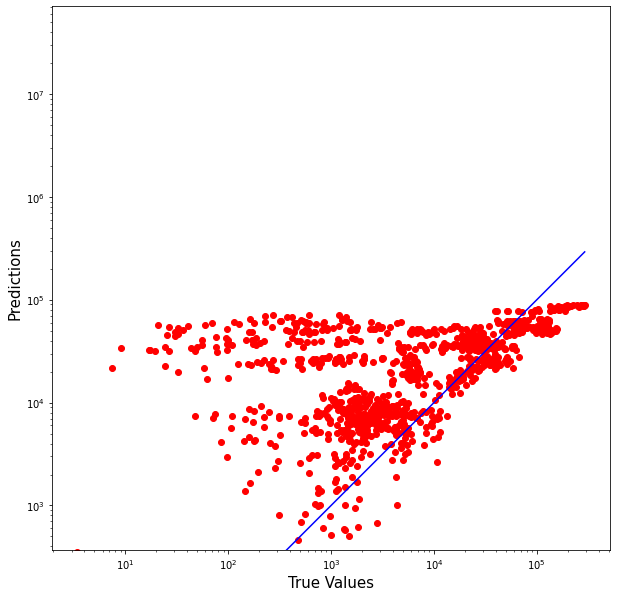

In [28]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, yhat, c='red')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(yhat), max(y_test))
p2 = min(min(yhat), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

# Define HyperOpt Search

We can use HyperOpt-Sklearn to find a good model for the power consumption dataset.

In this case, we want to optimize the MAE, therefore, we will set the “loss_fn” argument to the mean_absolute_error() function provided by the scikit-learn library.


In [29]:
# define search
model_hp = HyperoptEstimator(regressor=any_regressor('reg'), preprocessing=any_preprocessing('pre'), loss_fn=mean_absolute_error, algo=tpe.suggest, max_evals=50, trial_timeout=30)

# Fit the regression model with train data

In [30]:
model_hp.fit(X_train,y_train)

  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



100%|██████████| 1/1 [00:01<00:00,  1.03s/it, best loss: 12335.51488917136]
[04:29:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,



  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,



100%|██████████| 1/1 [00:01<00:00,  1.28s/it, best loss: 12335.51488917136]
[04:29:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,



  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



100%|██████████| 1/1 [00:00<00:00,  7.64it/s, best loss: 12335.51488917136]
[04:29:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:169: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  FutureWarning,



  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



100%|██████████| 1/1 [00:21<00:00, 21.59s/it, best loss: 10607.496109497892]
[04:30:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



100%|██████████| 1/1 [00:00<00:00,  1.65it/s, best loss: 10607.496109497892]
[04:30:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



100%|██████████| 1/1 [00:05<00:00,  5.44s/it, best loss: 10607.496109497892]
[04:30:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
100%|██████████| 1/1 [00:12<00:00, 12.26s/it, best loss: 9510.02873304512]
[04:31:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
100%|██████████| 1/1 [00:12<00:00, 12.40s/it, best loss: 9297.177548841559]
[04:31:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
100%|██████████| 1/1 [00:10<00:00, 10.87s/it, best loss: 9297.177548841559]
[04:31:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
100%|██████████| 1/1 [00:15<00:00, 15.07s/it, best loss: 9297.177548841559]
[04:31:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



100%|██████████| 1/1 [00:00<00:00,  3.40it/s, best loss: 9297.177548841559]
[04:32:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
100%|██████████| 1/1 [00:00<00:00,  3.98it/s, best loss: 9297.177548841559]
[04:32:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
100%|██████████| 1/1 [00:15<00:00, 15.93s/it, best loss: 9297.177548841559]
[04:32:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,



100%|██████████| 1/1 [00:08<00:00,  8.48s/it, best loss: 9297.177548841559]
[04:32:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



100%|██████████| 1/1 [00:00<00:00,  1.44it/s, best loss: 9297.177548841559]
[04:32:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# Summarize Performance and get the best model with best Hyper Parameters tuned

In [31]:
mae = model_hp.score(X_test, y_test)
print("MAE: %.3f" % mae)
# summarize the best model
print(model_hp.best_model())

MAE: 0.781
{'learner': XGBRegressor(colsample_bylevel=0.7534384355749768,
             colsample_bytree=0.8212340729916467, gamma=0.10329355786121369,
             learning_rate=0.0013165192177849241, max_depth=7,
             min_child_weight=3, missing=nan, n_estimators=3000,
             reg_alpha=0.7334294572526677, reg_lambda=2.010164195762124, seed=0,
             subsample=0.6577372629409339), 'preprocs': (MinMaxScaler(feature_range=(-1.0, 1.0)),), 'ex_preprocs': ()}


Since XGBoost came out as the best model for this dataset...

We will use ET model as our final model

In [36]:
from sklearn.ensemble import ExtraTreesRegressor
# from sklearn.ensemble import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [37]:
model_et = ExtraTreesRegressor(criterion='mse', max_features=None, min_samples_leaf=8,
                    n_estimators=29, n_jobs=1, random_state=2, verbose=False)

In [38]:
model_et.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


ExtraTreesRegressor(criterion='mse', max_features=None, min_samples_leaf=8,
                    n_estimators=29, n_jobs=1, random_state=2, verbose=False)

# Summarize performance of the ET model

In [39]:
mae = model_et.score(X_train, y_train)
print("MAE: %.3f" % mae)

MAE: 0.815


In [40]:
yhat = model_et.predict(X_test)
print('Predicted Class: %d' % yhat[0])

Predicted Class: 1255


In [ ]:
# df_output = pd.DataFrame({'Actual': y_test, 'Precition': yhat})

In [ ]:
# df_out = pd.merge(df_output,y_test[['preds']],how = 'left',left_index = True, right_index = True)

In [ ]:
# df_output.head(20)

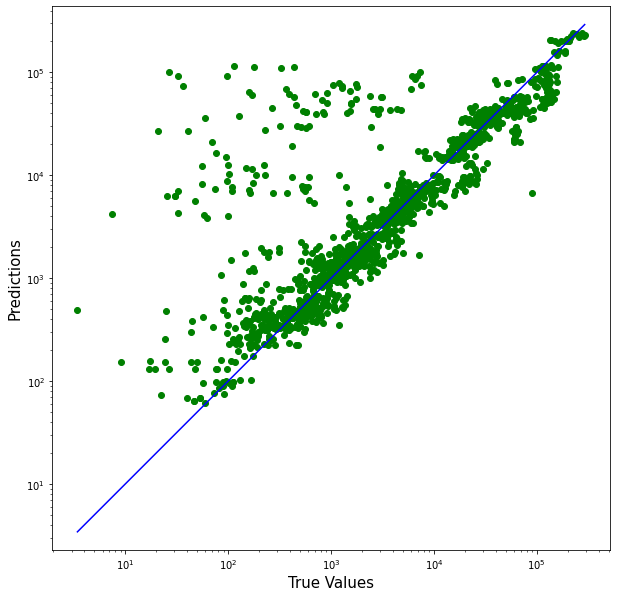

In [41]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, yhat, c='green')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(yhat), max(y_test))
p2 = min(min(yhat), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()